# 应用目的
根据天气在历史出现的概率，通过逻辑回归进行预测明天是否适合出行。


## 数据处理
将原始数据的日期，分为年, 月, 日, 将天气状况进行分类， 不适合出行天气(雨， 雾， 霾， 雪)设为0， 其他的为适合出行天气设为1，风向每天以(0, 0)为起点， 东西x做加减， 北南y做加减，求得它们的平方和根 $z = \sqrt{x^{2} + y^{2}}$

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from math import sqrt
from functools import reduce
%matplotlib inline



df = pd.read_excel('无锡市历史天气预报数据.xlsx', sheet_name=[8])[8]
df.columns = ['date', 'weather', 'temp', 'wind']
df.weather = df.weather.apply(lambda x: 0 if '雨' in x
                                          or '雾' in x 
                                          or '霾' in x 
                                          or '雪' in x else 1)
df['high'] = pd.Series(map(lambda x: re.search(r'\d+',x.split('/')[0])[0] ,df['temp'].values))
df['low'] = pd.Series(map(lambda x: re.search(r'\d+',x.split('/')[1])[0] ,df['temp'].values))

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
stength_list = []
dire_list = []
for i in range(len(df)):
    tmp = df.iloc[i]['wind']
    x = y = 0

    for ch in tmp:
        if ch == '东':
            x += 1
        elif ch == '南':
            y -= 1
        elif ch == '西':
            x -= 1
        elif ch == '北':
            y += 1
        
    dire_list.append(sqrt(pow(x, 2) + pow(y, 2)))
    try:
        tmp_list = re.findall(r'(\d)-(\d).*(\d)-(\d)', tmp)[0]
    except:
        tmp_list = [0]
    stength_list.append(reduce(lambda a, b: a + b, map(lambda x: int(x), tmp_list)) / len(tmp_list))
    
df['wind_dire'] = pd.Series(dire_list)
df['wind_strength'] = pd.Series(stength_list)
df.drop(['date', 'temp', 'wind'], axis=1, inplace=True)
df['high'] = df['high'].astype(int)
df['low'] = df['low'].astype(int)

Text(0,0.5,'Frequency')

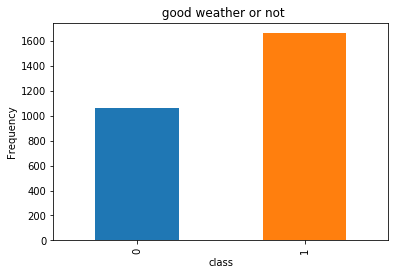

In [129]:
count_class = pd.value_counts(df['weather'], sort=True).sort_index()
count_class.plot(kind='bar')
plt.title(" good weather or not")
plt.xlabel("class")
plt.ylabel("Frequency")

可见分布不是特别均匀，处理一波, 随机抽取类型为1和类型为0的800条数据

Text(0,0.5,'Frequency')

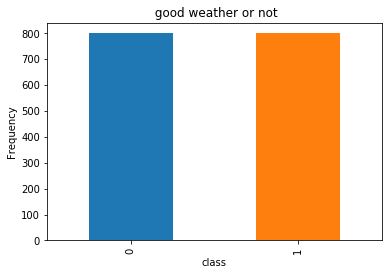

In [130]:
import numpy as np

good_index = df[df['weather'] == 1].index
good_random = np.random.choice(good_index,
                               800,
                               replace=False)
bad_index = df[df['weather'] == 0].index
bad_random = np.random.choice(bad_index,
                              800,
                              replace=False)

df1 = pd.concat([df.loc[good_random], df.loc[bad_random]])
count_class2 = pd.value_counts(df1['weather'], sort=True).sort_index()
count_class2.plot(kind='bar')
plt.title(" good weather or not")
plt.xlabel("class")
plt.ylabel("Frequency")


观察各个特征的相关性


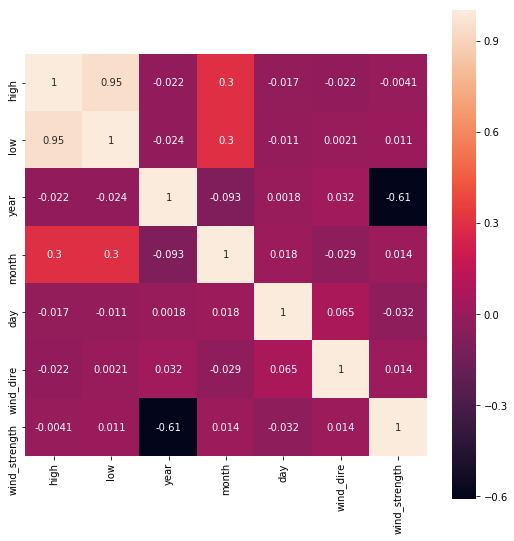

In [131]:
import seaborn as sns

x = df1.iloc[:, df1.columns != 'weather']
y = df1.iloc[:, df1.columns == 'weather']
corr = x.corr()

x
corr
plt.figure(figsize=(9, 9))
sns.heatmap(corr, square=True,annot=True)
#x

通过pca选取特征

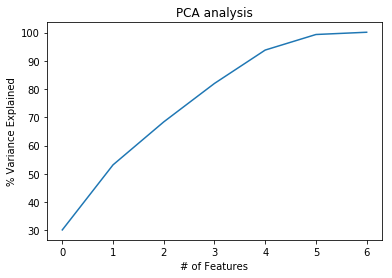

In [132]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 数据归一化
scaler = StandardScaler()
X = scaler.fit_transform(x)

# 应用pca， 7个特征
pca = PCA(n_components=7)
pca.fit(X)

var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3) * 100)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA analysis')

plt.plot(var)

使用逻辑回归

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score


# 初始化模型， 参数
X_train, X_test, y_train, y_test = train_test_split(X, y['weather'], test_size=0.3, random_state=1)
pca = PCA(n_components=7)
logReg = LogisticRegression()
pipe = Pipeline([('pca', pca), ('logistic', logReg)])

# 训练
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Intercept:', logReg.intercept_[0])
print(pd.DataFrame({'features': x.columns, 'coeficents': logReg.coef_[0]}))

# 评估
cm = confusion_matrix(y_test, y_pred)
print('Accuracy:', accuracy_score(y_test, y_pred))

Intercept: 0.018948262445112517
        features  coeficents
0           high    0.205609
1            low    0.149096
2           year   -0.094938
3          month   -0.081089
4            day    0.212911
5      wind_dire    0.219510
6  wind_strength   -4.138627
Accuracy: 0.675


预测明天是否适合出行， 其中最高温度，最低温度， 风向， 风力采用今天的值